In [202]:
import pandas as pd
import pandas_datareader as web
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

In [203]:
vix = web.DataReader( '^vix' , 'yahoo' , start = '2010-01-04', end = '2018-12-31')
spx = web.DataReader( '^GSPC' , 'yahoo' ,  start = '2010-01-04', end = '2018-12-31')
vxx = web.DataReader('vxx','yahoo',  start = '2010-01-04', end = '2018-12-31')


In [252]:
data = pd.DataFrame()
data['VIX'] = vix['Adj Close']
data['SPX'] = spx['Adj Close']
data['VXX'] = vxx['Adj Close']

In [253]:
data.head()

,VIX,SPX,VXX
Date,,,
2010-01-04,20.040001,1132.989990,33495.039062
2010-01-05,19.350000,1136.520020,32860.160156
2010-01-06,19.160000,1137.140015,31948.800781
2010-01-07,19.059999,1141.689941,31047.679688
2010-01-08,18.129999,1144.979980,30228.480469


In [257]:
data['VIX_Ret'] = data['VIX'].pct_change()
data['SPX_Ret'] = data['SPX'].pct_change()
data['VXX_Ret'] = data['VXX'].pct_change()
data = data[1:]

In [258]:
data.head()

,VIX,SPX,VXX,VIX_Ret,SPX_Ret,VXX_Ret
Date,,,,,,
2010-01-05,19.350000,1136.520020,32860.160156,-0.034431,0.003116,-0.018954
2010-01-06,19.160000,1137.140015,31948.800781,-0.009819,0.000546,-0.027734
2010-01-07,19.059999,1141.689941,31047.679688,-0.005219,0.004001,-0.028205
2010-01-08,18.129999,1144.979980,30228.480469,-0.048793,0.002882,-0.026385
2010-01-11,17.549999,1146.979980,29675.519531,-0.031991,0.001747,-0.018293


In [259]:
data_scaled = pd.DataFrame()
data_scaled['VIX'] = data['VIX'] / data.loc[ '2010-01-05']['VIX']
data_scaled['VXX'] = data['VXX'] / data.loc[ '2010-01-05']['VXX']
data_scaled['SPX'] = data['SPX'] / data.loc[ '2010-01-05']['SPX']


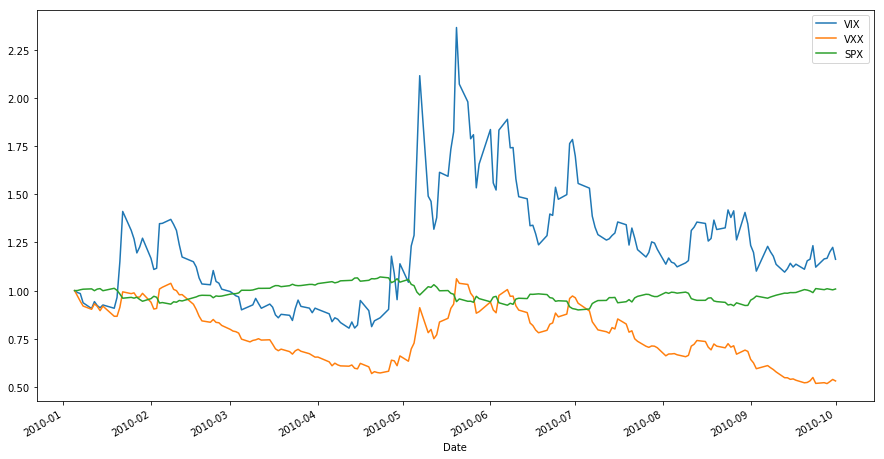

In [260]:
data_scaled.loc['2010-01-04':'2010-10-01'][['VIX','VXX','SPX']].plot(figsize = (15,8))
plt.legend()
plt.show()

In [261]:
#data.loc['2009-01-30':'2018-03-29']['VIX_Ret'].corr(data['VXX_Ret'])
cor_vxx_vix = data['VIX_Ret'].corr(data['VXX_Ret'])
cor_vxx_spx = data['VXX_Ret'].corr(data['SPX_Ret'])
print(f"The correlation between VIX_Ret and VXX_Ret is {cor_vxx_vix}, \nThe correlation between VXX_Ret and SPX_Ret is {cor_vxx_spx}")

The correlation between VIX_Ret and VXX_Ret is 0.8888372087155212, 
The correlation between VXX_Ret and SPX_Ret is -0.8302960490971283


In [262]:
R_vxx = np.nanmean(data['VXX_Ret'])
sigma_vxx = np.std(data['VXX_Ret'])

annualize_factor = 252
R_vxx_annualized = annualize_factor * R_vxx
sigma_vxx_annualized = np.sqrt(annualize_factor) * sigma_vxx

print(f"The R_vxx annualized is {R_vxx_annualized}\nThe sigma_vxx annualized is {sigma_vxx_annualized}\nThus, the price of the risk is {R_vxx_annualized/sigma_vxx_annualized}")

The R_vxx annualized is -0.5292213989949858
The sigma_vxx annualized is 0.6429871326223582
Thus, the price of the risk is -0.8230668580203303


In [234]:
data_subsample = data[['VIX','SPX', 'VXX_Ret']]
vix_price = data_subsample['VXX_Ret'].resample('Q',convention = 'end').mean()*annualize_factor / (data_subsample['VXX_Ret'].resample('Q',convention = 'end').std()*np.sqrt(annualize_factor))
#data_subsample['VIX_std'] = data_subsample['VIX_Ret'].resample('Q',convention = 'end').std()

In [235]:
vix_price =  vix_price.rename('VXX_price');

In [236]:
data_resample = data_subsample.resample('Q',convention = 'end').mean()
data_resample_new = pd.concat((data_resample,vix_price), axis = 1)

In [237]:
data_resample_new.head()

,VIX,SPX,VXX_Ret,VXX_price
Date,,,,
2010-03-31,20.151500,1123.436995,-0.006945,-3.790710
2010-06-30,26.391429,1134.584440,0.007683,2.279270
2010-09-30,24.283594,1096.246875,-0.008740,-4.644225
2010-12-31,19.318438,1204.585621,-0.009000,-4.620071
2011-03-31,18.614839,1302.529027,-0.003358,-1.481988


In [240]:
model_1 = sm.OLS(data_resample_new['VXX_price'], data_resample_new['SPX'])
results_1 = model_1.fit()
results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              VXX_price   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     9.856
Date:                Wed, 27 Mar 2019   Prob (F-statistic):            0.00343
Time:                        22:51:05   Log-Likelihood:                -83.215
No. Observations:                  36   AIC:                             168.4
Df Residuals:                      35   BIC:                             170.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SPX           -0.0007      0.000     -3.139      0.003      -0.001      -0.000
==============================================================================
Omnibus:                        1.108   Durbin-Watson:                   2.241
Prob(Omnibus):                  0.575   Jarque-Bera (JB):                1.055
Skew:                           0.380   Prob(JB):                        0.590
Kurtosis:                       2.643   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [266]:
cov_mat = np.cov(data['VXX_Ret'], data['SPX_Ret']) / (np.std(data['VXX_Ret'] * np.std(data['SPX_Ret'])))
beta = cov_mat[0][1]
print(f"The beta in the CAPM model is {beta}")

The beta in the CAPM model is -0.8306631118951383


In [272]:
price_capm = beta * np.mean(data['SPX_Ret'])*annualize_factor / (sigma_vxx*np.sqrt(annualize_factor))
print(f"The price of risk based on CAPM is {price_capm}")

The price of risk based on CAPM is -0.12882644820398215
